In [1]:
import matplotlib.pyplot as plt 
from scipy.io import readsav
import numpy as np
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from matplotlib import colors
import cmasher as cmr
import sunpy.cm as cm #The functionality of the sunpy.cm module is now in sunpy.visualization.colormaps as of SunPy 1.1
from tqdm import tqdm
from helita.io import lp
import COCOpy as cp
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
import matplotlib as mpl
from scipy import ndimage
import COCOpy as cp
import time
import multiprocessing as mp

In [2]:
dpath_SST = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/'
dpath_SST_processed = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/'
dpath_EDVARDA_SDO = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo2sst/' 
dpath_SDO_BOSE ='/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/cubes_nb/souvikb_CBP/SDO_only_aia/'
sdo_target_cubes = '/mn/stornext/d18/lapalma/reduc/2021/2021-08-04/CHROMIS/edvarda/sdo/target/cubes/'

# SST data

In [3]:
hdrH_im =lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
hdrH_sp = lp.getheader(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_sp.icube')
dimH_im = hdrH_im[0]
dimH_sp = hdrH_sp[0]
cubeH = lp.getdata(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cubeH = np.reshape(cubeH,[dimH_im[0],dimH_im[1],dimH_sp[1],dimH_sp[0]])

hdr_dopp = lp.getheader(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_dopp = hdr_dopp[0]
cube_dopp = lp.getdata(dpath_SST_processed+'Dopplergram_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_dopp = np.reshape(cube_dopp,[dim_dopp[0],dim_dopp[1],dim_dopp[2]])

hdr_rbe_mask = lp.getheader(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rbe_mask = hdr_rbe_mask[0]
cube_rbe_mask = lp.getdata(dpath_SST_processed+'Unshrped_RBEs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rbe_mask = np.reshape(cube_rbe_mask,[dim_rbe_mask[0],dim_rbe_mask[1],dim_rbe_mask[2]])

hdr_rre_mask = lp.getheader(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
dim_rre_mask = hdr_rre_mask[0]
cube_rre_mask = lp.getdata(dpath_SST_processed+'Unsrhped_RREs_nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im.icube')
cube_rre_mask = np.reshape(cube_rre_mask,[dim_rre_mask[0],dim_rre_mask[1],dim_rre_mask[2]])
#cube_dopp=np.swapaxes(cube_dopp,0,1)

time_steps = readsav(dpath_SST+'nb_4846_2021-08-04T09:56:50_scans=0-95_corrected_cmapcorr_im_times+wvl.idlsave')
times = time_steps['times']
wav = time_steps['LAMBDA']

In [4]:
wav[13]*1e1

4861.338090844452

In [5]:
# Equivalent line core width from H-alpha data (Cauzzi et al. 2008)
# Cauzzi et al. (2008) considered wavelength between \pm 0.9 \AA wrt line center of H-alpha.
# Converting that to equivalent Doppler velocities
H_alpha_wing_pos = 6563. -0.9
Dopp_wing = ((H_alpha_wing_pos - 6563.)/6563.)*3e5
print(Dopp_wing,'km/s') # According to H-alpha line profile

-41.13972268777859 km/s


In [6]:
# Converting this Doppler position to equivalent H-beta line wing position
H_beta_wing_pos = wav[13]*1e1+(Dopp_wing*wav[13]*1e1*.33e-5)
print(H_beta_wing_pos, r'$\AA$')
print('Region of interest wrt line center:'+r'$\pm', np.abs(H_beta_wing_pos - wav[13]*1e1))

4860.678110311321 $\AA$
Region of interest wrt line center:$\pm 0.659980533131602


In [7]:
wav[13]

486.1338090844452

# H-$\beta$ line-core width

In [37]:
def lp_hbeta_core_width(sp,ll):
    """
    Measures core width of Hbeta line profile
    sp : spectrum
    ll : wavelength positions relative to line center, in AA
    returns corewidth : width in AA (units ll)
    """
    from scipy.interpolate import interp1d
    if np.min(ll) > -0.66 or np.max(ll) < 0.66:
        print("spectral range should be in AA and at least cover -0.66 to +0.66 with respect to line center of H-beta i.e. 4861.33")
        print(ll)
    
    nl = len(ll)
    lrange = np.max(ll)-np.min(ll)
    spmax = np.max(sp)
    spmin = np.min(sp)
    maxp = np.argmax(sp)
    minp = np.argmin(sp)
    corewidth =0.
    if minp > 1 and minp < nl-2:
        m0 = np.min(np.abs(ll+0.66))
        m1 = np.min(np.abs(ll-0.66))
        l0 = np.argmin(np.abs(ll+0.66))
        l1 = np.argmin(np.abs(ll-0.66))
        if m0 < 0.001 and m1 < 0.001:
            avgw = np.mean([sp[l0],sp[l1]])
        else:
            y1 = sp[0:minp-1]
            x1 = ll[0:minp-1]
            f1 = interp1d(x1,y1,fill_value="extrapolate")
            sp0 = f1(-0.66)
            y2 = sp[minp+1:]
            x2 = ll[minp+1:]
            f2 = interp1d(x2,y2,fill_value="extrapolate")
            sp1 = f2(0.66)
            avgw = np.mean([sp0,sp1])
        y3 = ll[0:minp-1]
        x3 = sp[0:minp-1]
        f3 =interp1d(x3,y3,fill_value="extrapolate")
        ll0 = f3((avgw-spmin)/2.+spmin)
        y4 = ll[minp+1:]
        x4 = sp[minp+1:]
        f4 = interp1d(x4,y4,fill_value="extrapolate")
        ll1 = f4((avgw-spmin)/2.+spmin)
        corewidth=ll1-ll0
        if np.isfinite(corewidth)==0:
            corewidth =0
        if corewidth > lrange:
            corewidth = lrange
    return corewidth

In [27]:
ll=(wav - wav[13])*1e1

In [28]:
sp = cubeH[20,508,50,:]

In [33]:
start = time.time()
lp_hbeta_core_width(sp,ll)
end = time.time()
print((end-start)*1796*1138*96/96.)

2270.290334701538


In [24]:
def compute_linewidth_pixel(time_index):
    """ This function is written in order to 
    compute H_beta line core-width on a per pixel basis.
    
    Parameters
    ----------
    time_index: integer
        Time stamp of the 2D image.
    
    Returns
    -------
    width_2D: 2D array
        Line core width map for the chosen time stamp
    """
    ll = (wav - wav[13])*1e1
    size = np.shape(cubeH[:,:,time_index,:]) #(Nx,Ny,Nw)
    #mod_cubeH = cubeH[50:100,50:100,time_index,:]
    width_2D = np.zeros((size[0],size[1]))
    for row in range(size[0]):
        for col in range(size[1]):
            if np.all(cubeH[row,col,time_index,:]==279) == False:
                width_2D[row,col] = lp_hbeta_core_width(cubeH[row,col,time_index,:],ll)
            else:
                width_2D[row,col] = np.nan
    return width_2D

In [11]:
cubeH[50:100,50:100,10,:].shape

(50, 50, 27)

In [34]:
start = time.time()
width2 = compute_linewidth_pixel(12)
end = time.time()
print((end-start)/60.)

12.976808961232503


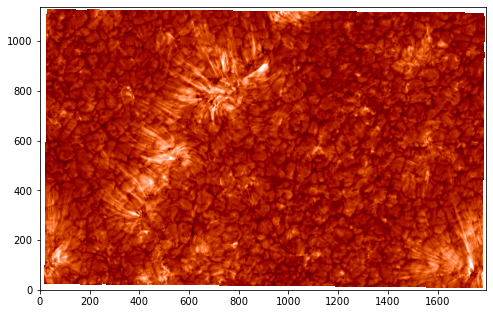

In [35]:
plt.figure(figsize=(8,8))
plt.imshow(width2.T,origin='lower',vmax=0.9,cmap='irissji1330',vmin=0.5)
#plt.colorbar()

In [38]:
pool = mp.Pool(60)
res1 = pool.map(compute_linewidth_pixel,range(0,96))
lc_widths = np.swapaxes(np.array(res1),0,2)
pool.close()
pool.join()

/astro/local/anaconda/lib/python3.7/site-packages/scipy/interpolate/interpolate.py:623: RuntimeWarning: divide by zero encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [39]:
hf = h5py.File(dpath_SST+'H_beta_widths_04.08.2021_CHROMIS.hdf5', 'w')
hf.create_dataset('Width', data = lc_widths)
hf.close()

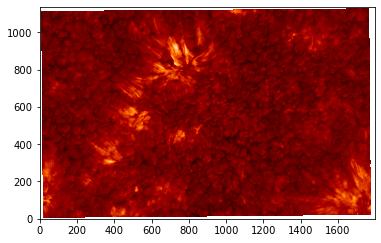

In [50]:
plt.imshow(lc_widths[:,:,90], origin ='lower',cmap='sdoaia304')

In [48]:
lc_widths1 = np.swapaxes(np.float32(lc_widths),0,1)
lc_widths1.dtype

dtype('float32')

In [49]:
lp.writeto(dpath_SST+'lc_widths_nb_4846_2021-08-04T09:56:50_scans=0-95.fcube', lc_widths1, extraheader='', dtype=None, verbose=False,
            append=False)